In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
# --- Imports ---
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from numf.peaks import get_neighbors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numf.utils import initialize_matrices
from numf.numf import numf
from scipy.interpolate import interp1d

np.random.seed(42)

<Axes: title={'center': 'Alpha, Delta, and Total Cases (2021)'}>

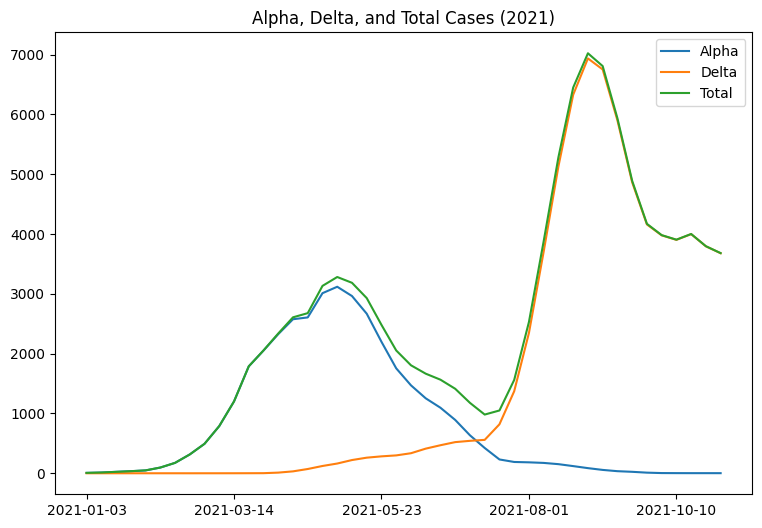

In [3]:
# Load 4-week averaged variant data and select Alpha and Delta for a specific period
df = pd.read_csv('../data/canada_variant_weekly_4w_avg.csv', index_col=0)
xdf = df.loc['2021-01-01':'2021-11-01', ['Alpha', 'Delta']]
xdf['Total'] = xdf.sum(axis=1)

xdf.plot(title="Alpha, Delta, and Total Cases (2021)", figsize=(9, 6))

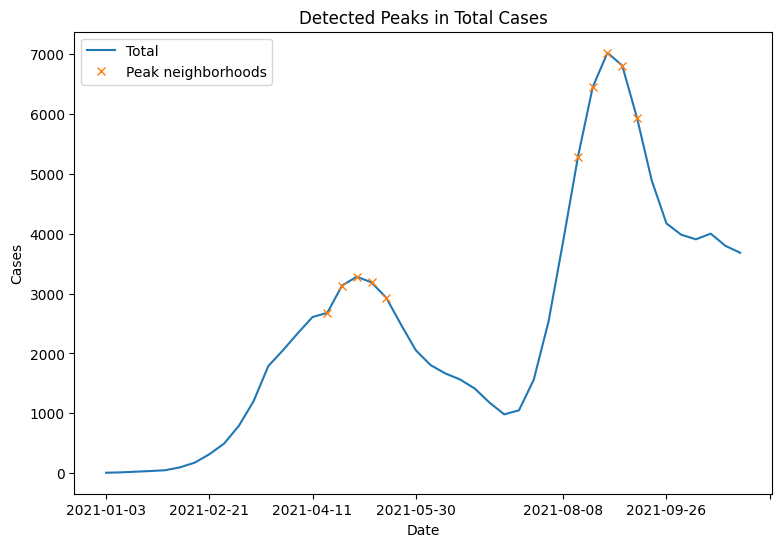

In [4]:
# Prepare matrix for NuMF
M0 = xdf['Total'].to_numpy().reshape(-1, 1)
m, n = M0.shape
r = 2  # Number of components

# Find peaks and their neighborhoods for unimodality constraints
peaks, _ = find_peaks(x=M0.reshape(m,), prominence=1, width=3)
pvals = get_neighbors(peaks, m, nrad=2)

plt.figure(figsize=(9, 6))
plt.plot(xdf.index, M0, label='Total')
plt.plot(xdf.index[pvals], M0[pvals], 'x', label='Peak neighborhoods')
plt.title("Detected Peaks in Total Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) 
plt.show()

In [5]:
# Initialize matrices for NuMF
W0, H0 = initialize_matrices(m, n, r)
iters = 5000

W1, H1, pouts1 = numf(M0, W0.copy(), H0.copy(), pvals=pvals, iters=iters, verbose=False)

# Run NuMF with area minimization penalty (beta=0.1)
W2, H2, pouts2 = numf(M0, W0.copy(), H0.copy(), pvals=pvals, beta=0.1, iters=iters, verbose=False)


Total Iteration 5000 | Final Loss: 0.003947
Total Iteration 5000 | Final Loss: 0.088673


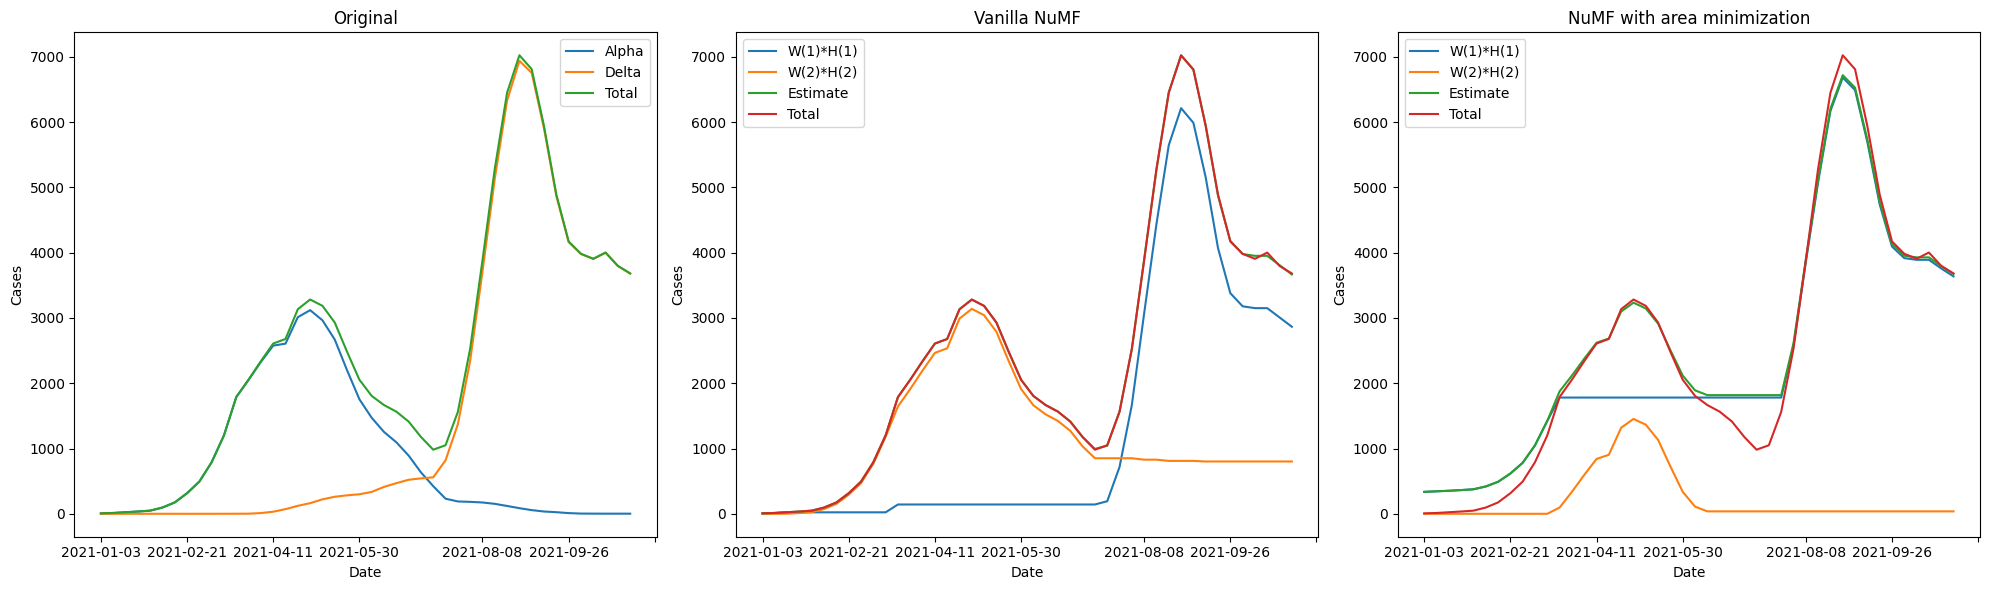

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Original data
axs[0].plot(xdf.index, xdf['Alpha'])
axs[0].plot(xdf.index, xdf['Delta'])
axs[0].plot(xdf.index, xdf['Total'])
axs[0].legend(['Alpha', 'Delta', 'Total'])
axs[0].set_title('Original')
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cases")
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())

# Vanilla NuMF
for i in range(r):
    axs[1].plot(xdf.index, W1[:, i] * H1[i, :])
axs[1].plot(xdf.index, W1 @ H1)
axs[1].plot(xdf.index, M0)
axs[1].legend(['W(1)*H(1)', 'W(2)*H(2)', 'Estimate', 'Total'])
axs[1].set_title('Vanilla NuMF')
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Cases")
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())

# NuMF with area minimization
for i in range(r):
    axs[2].plot(xdf.index, W2[:, i] * H2[i, :])
axs[2].plot(xdf.index, W2 @ H2)
axs[2].plot(xdf.index, M0)
axs[2].legend(['W(1)*H(1)', 'W(2)*H(2)', 'Estimate', 'Total'])
axs[2].set_title('NuMF with area minimization')
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Cases")
axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

In [7]:
# --- Disjoint & Extrapolation ---

# Helper for linear interpolation of NaNs
def interp_nans(y, x=None):
    if x is None:
        x = np.arange(len(y))
    nans = np.isnan(y)
    interpolator = interp1d(
        x[~nans],
        y[~nans],
        kind="linear",
        fill_value="extrapolate",
        assume_sorted=True,
    )
    return interpolator(x)

# Subtract minimum between peaks to create disjoint waves
threshold = min(M0[peaks[0]:peaks[1]])
M1 = M0 - threshold
M1[M1 < 0] = 0

Total Iteration 5000 | Final Loss: 0.005894


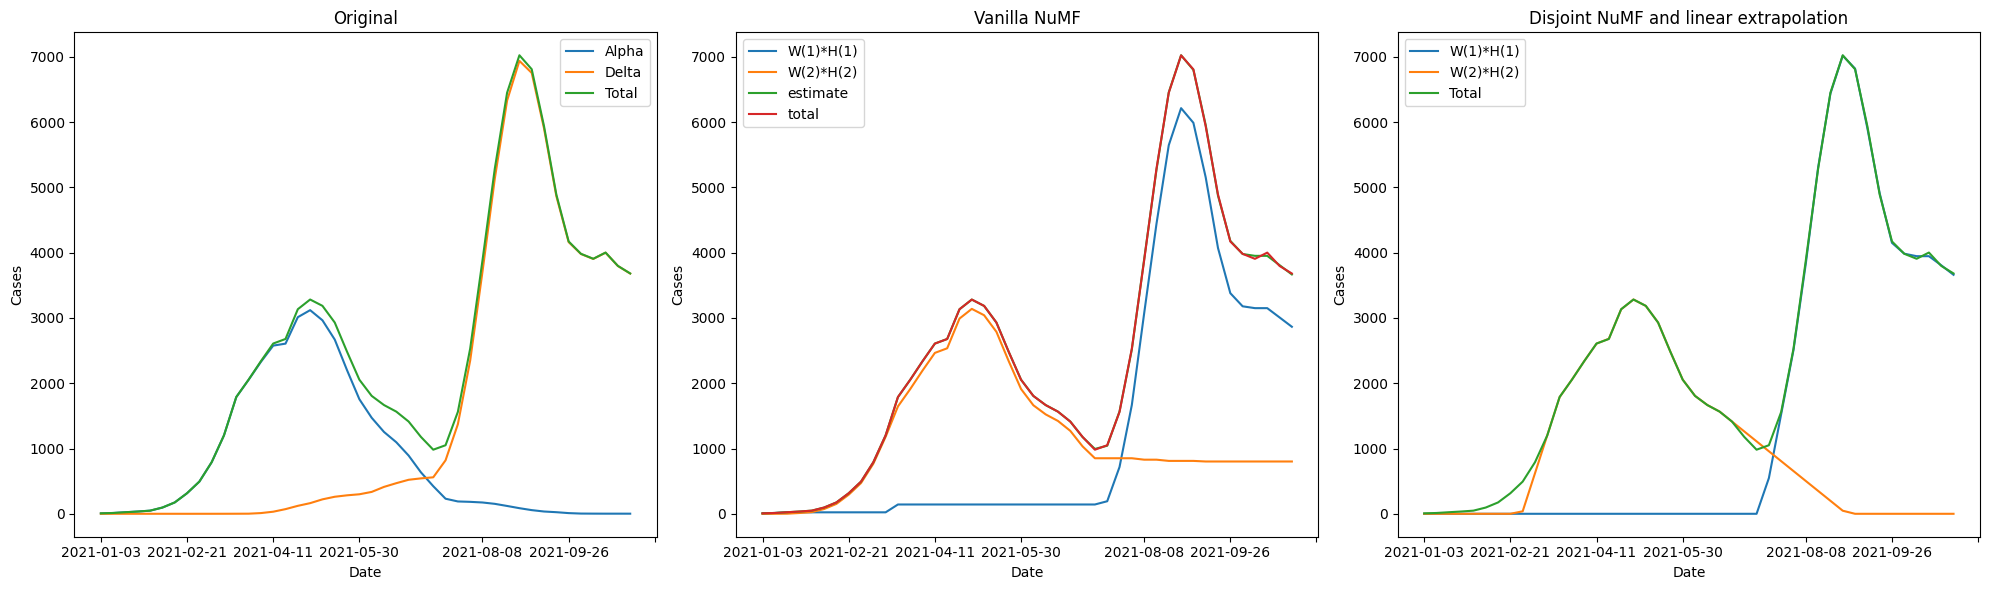

In [8]:
# Run NuMF on the disjointed data
W3, H3, pouts3 = numf(M1, W0.copy(), H0.copy(), pvals=pvals, iters=iters, verbose=False)

# Plot disjoint and extrapolated components against date
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Original data
axs[0].plot(xdf.index, xdf['Alpha'])
axs[0].plot(xdf.index, xdf['Delta'])
axs[0].plot(xdf.index, xdf['Total'])
axs[0].legend(['Alpha', 'Delta', 'Total'])
axs[0].set_title('Original')
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cases")
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())

# Vanilla NuMF
for i in range(r):
    axs[1].plot(xdf.index, W1[:, i] * H1[i, :])
axs[1].plot(xdf.index, W1 @ H1)
axs[1].plot(xdf.index, M0)
axs[1].legend(['W(1)*H(1)', 'W(2)*H(2)', 'estimate', 'total'])
axs[1].set_title('Vanilla NuMF')
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Cases")
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())

# Disjoint NuMF and linear extrapolation
for i in range(r):
    tmp = W3[:, i] * H3[i, :]
    xthres = 200
    arr = tmp > xthres
    tmp[arr] = tmp[arr] + threshold
    tmp[~arr] = np.nan
    new_tmp = interp_nans(tmp)
    new_tmp[new_tmp <= 0] = 0
    axs[2].plot(xdf.index, new_tmp)
axs[2].plot(xdf.index, M0)
axs[2].legend(['W(1)*H(1)', 'W(2)*H(2)', 'Total'])
axs[2].set_title('Disjoint NuMF and linear extrapolation')
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Cases")
axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()

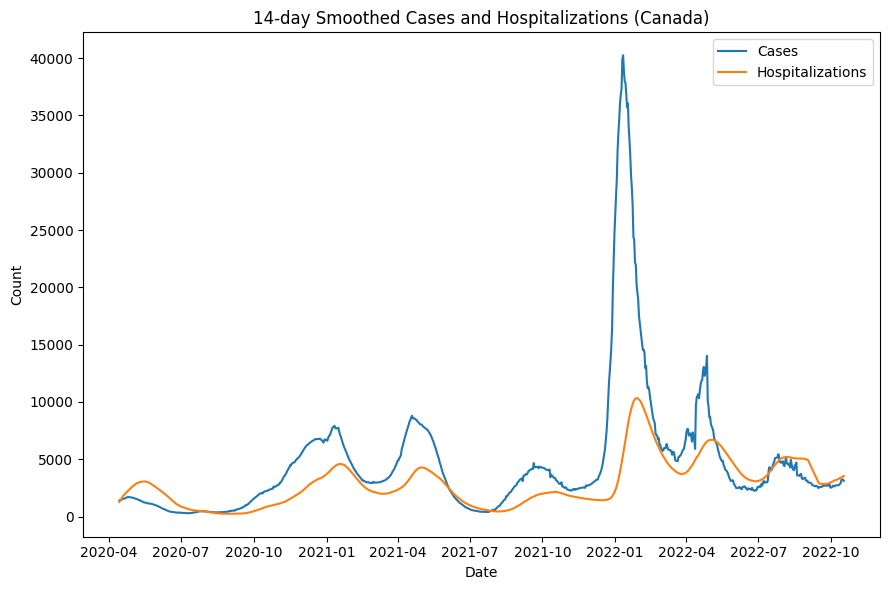

In [9]:
# --- Does using hospitalizations improve results? ---

# Load national case and hospitalization data
df2 = pd.read_csv('../data/owid-covid-data.csv', index_col=0)
df_can = df2[df2['location'] == 'Canada']
df_can.reset_index(inplace=True)

df_can = df_can[['date', 'new_cases', 'hosp_patients']]
df_can['date'] = pd.to_datetime(df_can['date'])

# Remove rows with NaN values
df_can = df_can[~df_can.isna().any(axis=1)]

# Apply 14-day rolling average smoothing
df_can['new_cases'] = df_can['new_cases'].rolling(window=14).mean()
df_can['hosp_patients'] = df_can['hosp_patients'].rolling(window=14).mean()
df_can = df_can[~df_can.isna().any(axis=1)]
df_can.set_index('date', inplace=True)

# Plot smoothed cases and hospitalizations
plt.figure(figsize=(9, 6))
plt.plot(df_can.index, df_can['new_cases'], label='Cases')
plt.plot(df_can.index, df_can['hosp_patients'], label='Hospitalizations')
plt.title("14-day Smoothed Cases and Hospitalizations (Canada)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.tight_layout()
plt.show()

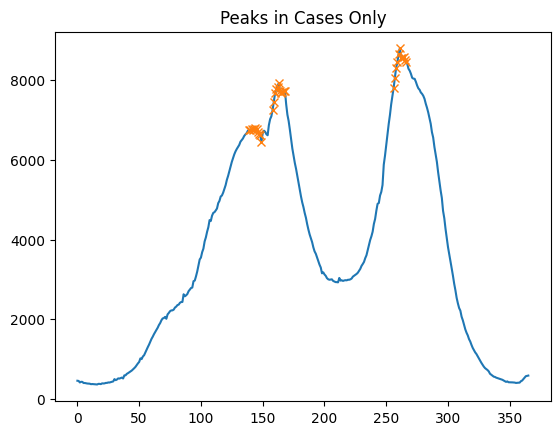

In [ ]:
# --- NuMF with and without hospitalizations ---

# Without hospitalizations (cases only)
M1d = df_can.loc['2020-08-01':'2021-08-01', 'new_cases'].to_numpy().reshape(-1, 1)
m, n = M1d.shape
peaks, _ = find_peaks(x=M1d.reshape(m,), prominence=1, width=3)
pvals = get_neighbors(peaks, m, nrad=5)
plt.figure()
plt.plot(M1d)
plt.plot(pvals, M1d[pvals], 'x')
plt.title("Peaks in Cases Only")
plt.show()

r = 6
iters = 500
W0, H0 = initialize_matrices(m, n, r)
W1, H1, pouts1 = numf(M1d, W0.copy(), H0.copy(), pvals=pvals, iters=iters)

# With hospitalizations (cases + hospitalizations)
M2d = df_can.loc['2020-08-01':'2021-08-01', :].to_numpy()
m, n = M2d.shape
peaks1, _ = find_peaks(x=M2d[:, 0].reshape(m,), prominence=1, width=3)
peaks2, _ = find_peaks(x=M2d[:, 1].reshape(m,), prominence=1, width=3)
xpvals = get_neighbors(np.append(peaks1, peaks2), m, nrad=5)
W0, H0 = initialize_matrices(m, n, r)
W2, H2, pouts2 = numf(M2d, W0.copy(), H0.copy(), pvals=xpvals, iters=iters)


In [ ]:
# --- Section 7: Compare reconstructions with and without hospitalizations ---

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(M2d)
axs[0].plot(W1 @ H1)
axs[0].plot(W2 @ H2)
axs[0].set_title('Original and Reconstructions')

for i in range(W1.shape[1]):
    axs[1].plot(W1[:, i] * H1[i, :])
    axs[2].plot(W2[:, i].reshape(m, 1) @ H2[i, :].reshape(1, n))
axs[1].set_title('Without hospitalizations')
axs[2].set_title('With hospitalizations')
plt.show()